# 实验课 12

## 实验12-1 k-近邻算法

k-近邻算法采用测量不同特征值之间的距离方法进行分类。一个对象的分类是由其邻居的“多数表决”确定的，k个最近邻居（k为正整数，通常较小）中最常见的分类决定了赋予该对象的类别。

例如在二维平面中有一些已知类别（用不同颜色标记）的点，现在我们有一个新的数据点（白色），如何确定该点所属的类别呢？

![KNN](img/Lab12-1-1.png)

你可能说这个点是和蓝色点属于同一类别的，因为该点周围大部分都是蓝色点。这就是k-近邻算法的简易思想：待分类数据周围k个点的大比数类别就是该数据的类别。

现在我们使用Scikit-Learn库中的k-近邻算法对鸢尾花进行简单分类，为了可视化方便，这里我们只利用花瓣长度（Petal Length）和花瓣宽度（Petal Width）作为数据特征，首先先进行数据集划分、再将训练集中的数据点可视化：

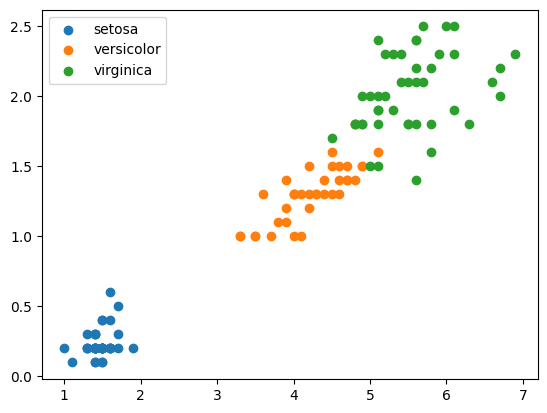

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

iris_data = load_iris()
x = iris_data['data'][:,2:]
y = iris_data['target']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)

dataframe = pd.DataFrame(x_train)
dataframe['y'] = y_train
plt.scatter(dataframe.loc[dataframe['y'] == 0][0],dataframe.loc[dataframe['y'] == 0][1],label=iris_data['target_names'][0])
plt.scatter(dataframe.loc[dataframe['y'] == 1][0],dataframe.loc[dataframe['y'] == 1][1],label=iris_data['target_names'][1])
plt.scatter(dataframe.loc[dataframe['y'] == 2][0],dataframe.loc[dataframe['y'] == 2][1],label=iris_data['target_names'][2])
plt.legend()
plt.show()

在建立k-近邻分类模型之前，我们需要考虑一个问题：k 应该取多少？

也许我们可以进行多次实验，分别赋予 k 不同的值，可是这样会给人一种为了达到测试集上最大正确性而去调节参数以“适应”测试集的感觉。测试集更像是“期末测验”，我们建立的模型应当不知道测试集的具体数据，只有模型训练完毕后才能将测试集输入模型，以检验模型的准确性和泛化能力。

实际上在训练集和测试集的基础上我们还要再建立一个**验证集**，验证集是模型训练过程中单独留出的样本集，它可以用于调整模型的超参数和用于对模型的能力进行初步评估。

对于小规模数据（万级别以下），训练集、验证集和测试集的比例建议为6:2:2；而对于大规模数据，比例建议为98:1:1.

我们常用的方法是k折交叉验证：将原始训练集数据分为k（注意这里的k与k-近邻的k不是一个含义!）组（一般是均分），将每个子集数据分别做一次验证集，其余的k-1组子集数据作为新训练集，这样会得到k个模型，用这k个模型的验证集的分类准确率的平均数作为模型的性能指标，进而选择较适合的超参数。

![VaildSet](img/Lab12-1-2.jpg)

Scikit-Learn库中提供了交叉验证方法帮助我们确定较合适的超参数，现在我们确定一下较合适的k值：

In [119]:
from sklearn.model_selection import cross_val_score

for k in range(3,20,2):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model,x_train,y_train)
    print(k,scores.mean())

3 0.95
5 0.9583333333333334
7 0.9666666666666668
9 0.9666666666666668
11 0.9666666666666668
13 0.9666666666666668
15 0.9666666666666668
17 0.9666666666666668
19 0.9583333333333334


我们看到k取7较为合适，现在我们建立一个7-近邻分类模型，并在测试集上进行测试。我们使用传统的正确率作为评测指标：模型对测试数据的预测标签与实际标签相同则记为成功预测。

In [120]:
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=7)
model.fit(x_train,y_train)
y_pre = model.predict(x_test)
acc_score = accuracy_score(y_test,y_pre)
print(acc_score)

0.9666666666666667


可以看到对测试集的数据分类准确率为96.67%

* ### 进一步改进

我们看到传统k-近邻算法中每个邻居无论远近，投票权重均相同，这样会造成一个问题，如图所示，直观来说Y点应属于红色类别，但是Y点的k-近邻中蓝色点居多，算法将其标记为蓝色类别。这样当样本分布不均衡时新的未知样本容易被归类为数量过大的主导样本。

我们可以考虑未知样本与近邻点的距离，根据距离远近设定权重，再统计各类别的权重和进行分类。

## 实验12-2 决策树

机器学习中，决策树（Decision tree）是一个预测模型，它代表的是对象属性与对象值之间的一种映射关系。树中每个节点表示某个对象，而每个分叉路径则代表某个可能的属性值，而每个叶节点则对应从根节点到该叶节点所经历的路径所表示的对象的值。数据挖掘中决策树是一种经常要用到的技术，可以用于分析数据，同样也可以用来作预测。

例如判断一个西瓜质量的好坏，我们从多个特征确定：

![Watermelon](img/Lab12-2-1.jpg)

分裂条件不仅可以是离散值，也可以是连续值，例如直径小于某个值时生成一个叶子节点。

在不加限制的情况下，一棵决策树会生长到衡量不纯度的指标最优，或者没有更多的特征可用为止。这样的决策树往往会过拟合，这就是说，它会在训练集上表现很好，在测试集上却表现糟糕。我们收集的样本数据不可能和整体的状况完全一致，因此当一棵决策树对训练数据有了过于优秀的解释性，它找出的规则必然包含了训练样本中的噪声，并使它对未知数据的拟合程度不足。

为了让决策树有更好的泛化性，我们要对决策树进行剪枝。剪枝策略对决策树的影响巨大，正确的剪枝策略是优化决策树算法的核心。在这里我们采取预剪枝策略，限制决策树的最大深度，最大深度一般大于等于3而小于等于特征数量。

现在我们再利用鸢尾花数据集，利用四个特征对鸢尾花进行三分类。

In [121]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

iris_data = load_iris()
x = iris_data['data']
y = iris_data['target']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)

for k in range(3,len(iris_data['feature_names'])+1):
    model = DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(model,x_train,y_train)
    print(k,scores.mean())

3 0.9333333333333333
4 0.9333333333333333


In [122]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train,y_train)
y_pre = model.predict(x_test)
acc_score = accuracy_score(y_test,y_pre)
print(acc_score)

0.9666666666666667


我们可以使用Graphviz工具可视化刚才生成的决策树！

Windows用户请首先[按此](https://www2.graphviz.org/Packages/stable/windows/10/cmake/Release/x64/graphviz-install-2.44.1-win64.exe)下载并安装Graphviz，安装时注意请**勾选添加系统变量**。

MacOS用户请参考[这个网页](https://graphviz.org/download/)进行安装。

然后请在Anaconda Powershell Prompt命令行中输入

`conda install graphviz`

`conda install pydotplus`

In [123]:
import pydotplus
from sklearn import tree

dot_data = tree.export_graphviz(model, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("iris.pdf")

True

生成的可视化决策树存放于PDF文件中。

## 实验练习12

互联网中充斥着大量钓鱼欺诈类网站。这类非法网站通常试图掩人耳目、充当正规网站，而实际上却是在窃取用户的身份、密码、交易等重要信息。

![Web](img/Lab12-E-1.jpg)

机器学习在信息安全领域中的一个重要应用就是用来识别这些钓鱼网站。

`fraudulent.csv`文件中含有10,086条数据，每条数据含有18个特征以及1个标签。各个特征的含义如下：

1. contain_IP：网址中是否包涵ip，比如`http://121.99.3.123/fake.html` 包含ip。1表示包含，0表示不包含；
2. is_long：网址字符是否过长。1表示网址过长，0表示网址不长；
3. is_tinyurl：网址是否是短网址。比如`https://bit.ly/2kXX6jV` 就是短网址。1表示是短网址，0表示不是；
4. contain_at：网址是否包含“@”符号。1表示包含，0表示不包含；
5. contain_double_slash：网址是否包含“//”符号，该符号用来表示网址跳转。1表示包含，0表示不包含；
6. contain_dash：网址是否包含“-”符号，该符号经常帮助用来伪装真网站，比如`www.my-taobao.com` 。 1表示包含，0表示不包含；
7. contain_subdomain：网址是否包含子域名，比如`www.ecnu.edu.cn` 就包含edu和cn子域名。1表示包含，0表示不包含；
8. is_SSL：网址是否是https安全链接。1表示包含，0表示不包含；
9. with_long_history：网址所属的主域名存在的时间。1表示长久，0表示不长久；
10. contain_icon：网址网页是否有小图标。1表示包含，0表示不包含；
11. contain_ext_domain：该网页是否加载其他域名下的附件或者网页。1表示包含，0表示不包含；
12. contain_email_to：该网页是否包含发送邮件的组件。1表示包含，0表示不包含；
13. allow_right_click：该网页是否允许用户进行右击操作。1表示允许，0表示不允许；
14. contain_pop_up_windowL：该网页是否包含弹窗。1表示包含，0表示不包含；
15. contain_Iframe：该网页是否包含Iframe（嵌套网页）。1表示包含，0表示不包含；
16. has_DNSRecord：网址是否有DNS记录。1表示有，0表示无；
17. traffic：该网站的流量大小。1表示大，0表示小；
18. google_rank：该网址在google搜索中的排名。1表示高于同类网站的平均排名，0表示低于同类网站的平均排名；
* **y：表示网站是否是钓鱼欺诈网站，1表示是，0表示不是。**

原始数据中含有大量缺失值，请自行处理这些缺失值（可以剔除缺失值过多的列或者使用众数填充等方法）。

将原始数据分为训练集、测试集（随机种子请设置为1）（若有需要可以将训练集进一步分为训练集和验证集）。

现在请建立一个二分类模型，使用训练集训练模型，再使用测试集测试模型。

评估指标为F1值（[详细解释](https://blog.csdn.net/xiaodongxiexie/article/details/67009112)）

分类模型可采用：k-近邻、决策树、逻辑回归、支持向量机等。

可以与周围同学比较一下F1值的大小（越接近1越好），看看谁的数据预处理和分类模型更强。

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

dataset =pd.read_csv('fraudulent.csv')

# 剔除缺失值过多的列（例如超过50%的缺失）
dataset = dataset.dropna(thresh=len(dataset) * 0.5, axis=1)

# 使用众数填充剩余的缺失值
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

X = data_imputed.drop(columns=['y'])
y = data_imputed['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model=DecisionTreeClassifier(random_state=1)

model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
f1=f1_score(y_test, y_pred)
print(f1)



0.8667198723064645
